In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import tensorflow as tf
from keras.preprocessing.text import one_hot,Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation,Dropout,Dense
from keras.layers import Flatten,GlobalMaxPooling1D,Embedding,Conv1D,LSTM
from sklearn.model_selection import train_test_split

In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
data=pd.read_csv('./IMDB Dataset.csv')

In [4]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
data.shape

(50000, 2)

In [6]:
data.isna().sum()

review       0
sentiment    0
dtype: int64

In [7]:
data.dtypes

review       object
sentiment    object
dtype: object

In [8]:
data.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [9]:
data.sentiment.dtype


dtype('O')

<Axes: xlabel='sentiment', ylabel='count'>

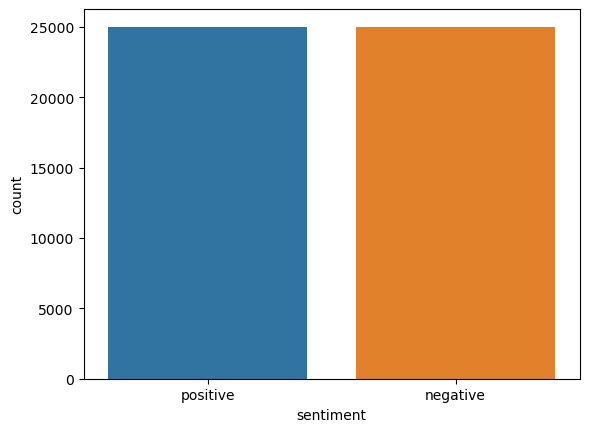

In [10]:
import seaborn as sns
sns.countplot(x='sentiment',data=data)

In [11]:
tag_remover=re.compile(r'<[^>]+>')
def remove_tags(text):
    return tag_remover.sub(" ",text)

In [12]:
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [13]:
def preprocess_data(sent):
    sentence=sent.lower()
    sentence=remove_tags(sentence)
    sentence=re.sub(r'[^a-zA-Z]',' ',sentence)
    sentence=re.sub(r'\s+[a-zA-Z]\s+',' ',sentence)
    sentence=re.sub(r'\s+'," ",sentence)
    # remove stopwords
    pattern=re.compile(r'\b('+r'|'.join(stopwords.words('english'))+r')\b\s*')
    sentence=pattern.sub(" ",sentence)
    return sentence

In [14]:
s=data.iloc[2,0]
s

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [15]:
preprocess_data(s)

' thought   wonderful way  spend time   hot summer weekend sitting   air conditioned theater  watching light hearted comedy  plot  simplistic   dialogue  witty   characters  likable even  well bread suspected serial killer   may  disappointed   realize    match point risk addiction thought   proof  woody allen  still fully  control   style many  us  grown  love      laughed  one  woody comedies  years dare say decade   never  impressed  scarlet johanson    managed  tone   sexy image  jumped right  average  spirited young woman  may    crown jewel   career    wittier  devil wears prada   interesting  superman great comedy  go see  friends '

In [16]:
x=data.review.apply(preprocess_data)

In [17]:
data.review=x

In [18]:
data.head()

,review,sentiment
0,one reviewers mentioned watching oz epi...,positive
1,wonderful little production filming techniqu...,positive
2,thought wonderful way spend time hot sum...,positive
3,basically family little boy jake thinks z...,negative
4,petter mattei love time money visually stu...,positive


In [19]:
data.sentiment=data.sentiment.apply(lambda x: 1 if x=='positive' else 0)

In [20]:
data.head()

,review,sentiment
0,one reviewers mentioned watching oz epi...,1
1,wonderful little production filming techniqu...,1
2,thought wonderful way spend time hot sum...,1
3,basically family little boy jake thinks z...,0
4,petter mattei love time money visually stu...,1


In [21]:
x_train,x_test,y_train,y_test=train_test_split(data.review,data.sentiment,test_size=0.20,random_state=12)

In [22]:
word_tokenizer=Tokenizer()
word_tokenizer.fit_on_texts(x_train)

In [23]:
x_train=word_tokenizer.texts_to_sequences(x_train)

In [24]:
x_test=word_tokenizer.texts_to_sequences(x_test)

In [28]:
vocab_length=len(word_tokenizer.word_index)+1
vocab_length

90508

In [29]:
x_train=pad_sequences(x_train,padding='post',maxlen=100)
x_test=pad_sequences(x_test,padding='post',maxlen=100)


In [30]:
x_train

array([[ 2720,    18,   497, ...,     0,     0,     0],
       [   84,  4168, 56652, ...,  5591,  1957,  5794],
       [    4,    75,    80, ...,     0,     0,     0],
       ...,
       [39554,  1808, 31192, ...,     9,    15,     1],
       [35976, 25198,   609, ...,  3344,  2671, 25916],
       [  233,   263,    36, ...,     0,     0,     0]])

In [31]:
embedding_dict=dict()
glove_file=open("./glove.6B.100d.txt",encoding='utf8')
for line in glove_file:
    records=line.split()
    word=records[0]
    vector_dimensions=np.asarray(records[1:],dtype='float32')
    embedding_dict[word]=vector_dimensions

glove_file.close()

In [32]:
embedding_matrix=np.zeros((vocab_length,100))
for word,index in word_tokenizer.word_index.items():
    embedding_vector=embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[index]=embedding_vector

In [33]:
snn=Sequential()
embedding_layer=Embedding(input_dim=vocab_length,output_dim=100,weights=[embedding_matrix],input_length=100,trainable=False)
snn.add(embedding_layer)
snn.add(Flatten())
snn.add(Dense(1,activation='sigmoid'))


In [34]:
snn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
snn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9050800   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 9060801 (34.56 MB)
Trainable params: 10001 (39.07 KB)
Non-trainable params: 9050800 (34.53 MB)
_________________________________________________________________


In [36]:
snn_history=snn.fit(x_train,y_train,batch_size=100,epochs=50,verbose=2,validation_split=0.2)

Epoch 1/50
320/320 - 2s - loss: 0.3198 - accuracy: 0.8628 - val_loss: 0.6643 - val_accuracy: 0.7352 - 2s/epoch - 5ms/step
Epoch 2/50
320/320 - 2s - loss: 0.3163 - accuracy: 0.8644 - val_loss: 0.6785 - val_accuracy: 0.7350 - 2s/epoch - 5ms/step
Epoch 3/50
320/320 - 2s - loss: 0.3120 - accuracy: 0.8653 - val_loss: 0.6862 - val_accuracy: 0.7337 - 2s/epoch - 5ms/step
Epoch 4/50
320/320 - 2s - loss: 0.3090 - accuracy: 0.8678 - val_loss: 0.7000 - val_accuracy: 0.7312 - 2s/epoch - 5ms/step
Epoch 5/50
320/320 - 2s - loss: 0.3069 - accuracy: 0.8697 - val_loss: 0.7089 - val_accuracy: 0.7336 - 2s/epoch - 5ms/step
Epoch 6/50
320/320 - 2s - loss: 0.3025 - accuracy: 0.8711 - val_loss: 0.7297 - val_accuracy: 0.7286 - 2s/epoch - 5ms/step
Epoch 7/50
320/320 - 2s - loss: 0.3027 - accuracy: 0.8725 - val_loss: 0.7289 - val_accuracy: 0.7299 - 2s/epoch - 5ms/step
Epoch 8/50
320/320 - 2s - loss: 0.3005 - accuracy: 0.8732 - val_loss: 0.7557 - val_accuracy: 0.7239 - 2s/epoch - 5ms/step
Epoch 9/50
320/320 - 2s 

In [37]:
snn.save("./snn.keras")

In [38]:
score=snn.evaluate(x_test,y_test,verbose=2)

313/313 - 1s - loss: 1.0226 - accuracy: 0.7165 - 1s/epoch - 4ms/step


In [39]:
score

[1.0226389169692993, 0.7164999842643738]

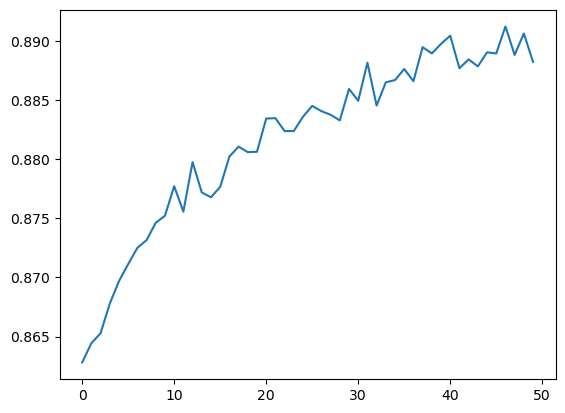

In [41]:
from matplotlib import pyplot as plt
plt.plot(snn_history.history['accuracy'])

In [42]:
cnn_model=Sequential()
cnn_model.add(embedding_layer)
cnn_model.add(Conv1D(128,5,activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1,activation='sigmoid'))

In [45]:
cnn_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9050800   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9115057 (34.77 MB)
Trainable params: 64257 (251.00 KB)
Non-trainable params: 9050800 (34.53 MB)
_________________________________________________________________
None


In [46]:
cnn_history=cnn_model.fit(x_train,y_train,batch_size=100,epochs=20,verbose=2,validation_split=0.2)

Epoch 1/20
320/320 - 10s - loss: 0.4557 - acc: 0.7839 - val_loss: 0.4027 - val_acc: 0.8173 - 10s/epoch - 32ms/step
Epoch 2/20
320/320 - 9s - loss: 0.3248 - acc: 0.8598 - val_loss: 0.3544 - val_acc: 0.8435 - 9s/epoch - 27ms/step
Epoch 3/20
320/320 - 9s - loss: 0.2663 - acc: 0.8934 - val_loss: 0.3463 - val_acc: 0.8456 - 9s/epoch - 27ms/step
Epoch 4/20
320/320 - 9s - loss: 0.2175 - acc: 0.9203 - val_loss: 0.3499 - val_acc: 0.8453 - 9s/epoch - 27ms/step
Epoch 5/20
320/320 - 9s - loss: 0.1765 - acc: 0.9430 - val_loss: 0.3769 - val_acc: 0.8371 - 9s/epoch - 27ms/step
Epoch 6/20
320/320 - 9s - loss: 0.1367 - acc: 0.9629 - val_loss: 0.3575 - val_acc: 0.8461 - 9s/epoch - 27ms/step
Epoch 7/20
320/320 - 9s - loss: 0.1049 - acc: 0.9786 - val_loss: 0.3633 - val_acc: 0.8495 - 9s/epoch - 28ms/step
Epoch 8/20
320/320 - 9s - loss: 0.0808 - acc: 0.9876 - val_loss: 0.3807 - val_acc: 0.8453 - 9s/epoch - 29ms/step
Epoch 9/20
320/320 - 9s - loss: 0.0621 - acc: 0.9936 - val_loss: 0.3954 - val_acc: 0.8440 - 9s

In [47]:
cnn_model.save("./cnn.keras")

In [48]:
score=cnn_model.evaluate(x_test,y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.5530 - acc: 0.8477


In [49]:
lstm_model=Sequential()
lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))
lstm_model.add(Dense(1,activation='sigmoid'))


In [50]:
lstm_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9050800   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9168177 (34.97 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 9050800 (34.53 MB)
_________________________________________________________________


In [51]:
lstm_model.fit(x_train,y_train,epochs=10,batch_size=100,verbose=2,validation_split=0.2)


Epoch 1/10
320/320 - 63s - loss: 0.5006 - acc: 0.7545 - val_loss: 0.4398 - val_acc: 0.8030 - 63s/epoch - 197ms/step
Epoch 2/10
320/320 - 62s - loss: 0.4084 - acc: 0.8216 - val_loss: 0.3830 - val_acc: 0.8316 - 62s/epoch - 193ms/step
Epoch 3/10
320/320 - 60s - loss: 0.3667 - acc: 0.8446 - val_loss: 0.3875 - val_acc: 0.8454 - 60s/epoch - 187ms/step
Epoch 4/10
320/320 - 61s - loss: 0.3398 - acc: 0.8567 - val_loss: 0.3484 - val_acc: 0.8481 - 61s/epoch - 190ms/step
Epoch 5/10
320/320 - 61s - loss: 0.3149 - acc: 0.8702 - val_loss: 0.3423 - val_acc: 0.8584 - 61s/epoch - 192ms/step
Epoch 6/10
320/320 - 60s - loss: 0.2918 - acc: 0.8797 - val_loss: 0.3489 - val_acc: 0.8485 - 60s/epoch - 186ms/step
Epoch 7/10
320/320 - 61s - loss: 0.2745 - acc: 0.8886 - val_loss: 0.3292 - val_acc: 0.8651 - 61s/epoch - 191ms/step
Epoch 8/10
320/320 - 60s - loss: 0.2522 - acc: 0.8988 - val_loss: 0.3475 - val_acc: 0.8673 - 60s/epoch - 189ms/step
Epoch 9/10
320/320 - 63s - loss: 0.2333 - acc: 0.9079 - val_loss: 0.3372

In [52]:
lstm_model.save("./lstm.keras")

In [53]:
import sqlite3 as sql


In [54]:
con=sql.connect("./IMDB_Movies_2021.db")


In [55]:
curser=con.cursor()

In [59]:
x=con.execute("select * from REVIEWS")
con.commit()

In [62]:
review=pd.read_sql("select * from REVIEWS",con)

In [64]:
rev=review[['REVIEW']]

In [66]:
rev['REVIEW']=rev['REVIEW'].apply(preprocess_data)

C:\Users\asus\AppData\Local\Temp\ipykernel_5144\4029508385.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rev['REVIEW']=rev['REVIEW'].apply(preprocess_data)


In [68]:
unseen_tokenized=word_tokenizer.texts_to_sequences(rev['REVIEW'])

In [71]:
unseen_padded=pad_sequences(unseen_tokenized,padding='post',maxlen=100)


In [72]:
unseen_pred=lstm_model.predict(unseen_padded)

171/171 [==============================] - 6s 35ms/step


In [73]:
unseen_pred

array([[0.03416785],
       [0.87969536],
       [0.9664205 ],
       ...,
       [0.833278  ],
       [0.10669713],
       [0.99750775]], dtype=float32)

In [74]:
review.head()

,ID,REVIEW,RATING,AUTHOR,TITLE
0,1,I don't get all the terrible reviews for this ...,5.0,margarida-44311,Not Bad\n
1,2,I cannot believe anyone could give this film l...,8.0,joemay-2,What are all the bad reviews about is it a wo...
2,3,Great White is not the worst way to spend 90 m...,4.0,nebk,Great White=Jaws Lite\n
3,4,Great White is as basic of a killer shark film...,4.0,kuarinofu,Bare-bones killer shark film\n
4,5,"Terrible story, dialogue and CGI. The film has...",4.0,Horror_Flick_Fanatic,"Terrible story, dialogue, and CGI\n"


In [75]:
review['rat']=unseen_pred*5

In [76]:
review.head(20)

,ID,REVIEW,RATING,AUTHOR,TITLE,rat
0,1,I don't get all the terrible reviews for this ...,5.0,margarida-44311,Not Bad\n,0.170839
1,2,I cannot believe anyone could give this film l...,8.0,joemay-2,What are all the bad reviews about is it a wo...,4.398477
2,3,Great White is not the worst way to spend 90 m...,4.0,nebk,Great White=Jaws Lite\n,4.832102
3,4,Great White is as basic of a killer shark film...,4.0,kuarinofu,Bare-bones killer shark film\n,0.079242
4,5,"Terrible story, dialogue and CGI. The film has...",4.0,Horror_Flick_Fanatic,"Terrible story, dialogue, and CGI\n",0.088112
5,6,Whilst the 'shark survival' sub genre has plen...,6.0,NickyDee07938,A decent effort\n,0.026098
6,7,Much better than the ratings suggest. Its on p...,9.0,Novelwolf,Nice Shark movie!\n,0.442408
7,8,"First of all I love the film locations, drone ...",5.0,mbnn,"Nice, but could be so much better\n",0.062800
8,9,The film is meh when it comes to these types o...,4.0,phobicsq,Typical movie for the genre\n,0.162343
9,10,Thought it was a great Shark Movie . Special e...,7.0,rotini-52586,Liked it !\n,4.911014
